# 6 Optimizing Farametric Functions, Integration, and ODEs

We will cover two things today:

1. Numerical integration of ODE systems
2. Numerical optimization

First of all we include some basic packages to allow us to make nice-looking plots, manipulate data, ...:

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## Some Motivation for Numerical Integration

Let's say we have a system, defined as a system of differential equations

$$
\frac{d\mathbf{y}}{dt} = f(t, \mathbf{y}(t))
$$

where $\mathbf{y}$ represents some vector of dependent variables, $t$ is time, and the system has some specified initial condition $\mathbf{y}(t_0) = \mathbf{y}_0 $.

In a number of cases, we can find an analytical solution through direct integration or other means. 
**Eventually, finding an analytical solution becomes tricky or intractable (this is the case in most real-world ODE models, particularly nonlinear ODE systems). **
At that point it is necessary to find a numerical approximation to the 'real' solution, which is where numerical integration comes in.

We will be dealing today with the case of initial value problems, as defined above.

### The Euler Method

In the general definition of the system above, the right hand side of the equation defines the rate of change of some quantity $\mathbf{y}$ with respect to time.

We won't go into the derivation here, but for a sufficiently small time step, the slope will not change much and so a sequence of points can be computed by iteratively computing this rate of change ($f(t,y)$) based on the value of a previous point and a time increment $h$:

$$
y_{n+1} = y_n + h(f(t_n, y_n))
$$

This is the most basic form of numerical integration, the so called Euler method.
Let's make an example to see how it works, by integrating the function

$$
\frac{dy}{dt} = -y(t)
$$

whose exact solution is

$$
y(t) = y_0 \cdot e^{-t}
$$

where $y_0$ is the initial value of the system.

In [2]:
def rhs_function(y, t):
    '''
    The right hand side of our ODE.
    '''
    dydt = -y
    return dydt

In [3]:
def real_solution(y0, t):
    '''
    The real (analytical) solution to the ODE
    '''
    return y0*np.exp(-t)

In [4]:
def euler_solve(t0, t1, h, y0, func):
    '''
    Solve a simple equation using the Euler method
        t0: initial time
        t1: final time
        h: integration timestep
        y0: initial function value
        func: the function to integrate
    '''
    # Generate all timesteps
    T = np.arange(t0, t1, h)
    
    # Pre-allocate space for output
    Y = np.empty(T.shape)

    # Set the initial value
    Y[0] = y0

    # Iterate over timesteps
    for i in range(len(T) - 1):
        # The value at the next timestep is equal to
        # the current value, plus the rate of change multiplied by the timestep.
        Y[i + 1] = Y[i] + h*func(Y[i], T[i])
    
    return T,Y

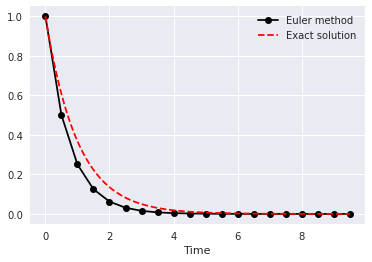

In [5]:
t0 = 0
t1 = 10
h = 0.5

y0 = 1.0

T, Y = euler_solve(t0, t1, h, y0, rhs_function)
t_fine = np.linspace(T[0], T[-1], 1000)

plt.plot(T, Y, 'k-o')
plt.plot(t_fine, real_solution(y0, t_fine), 'r--')
plt.xlabel('Time')
plt.legend(['Euler method', 'Exact solution'])

As you can see, the smaller the timestep becomes the closer our numerical soultion converges to the real solution.

The Euler method is low order, and requires a small timestep in general in order to converge to a correct solution.
However it is important to note is that (despite its low-order nature) it is quite useful in the case where you need to include stochastic elements in the dynamics (e.g., a noise term modelled as a Wiener process).

In these cases, higher-order methods in their default formulation do not take into account additional noise terms and will generally provide an incorrect solution or flat out not work. 

## Solving Initial Value Problems in SciPy

### 1. Using `scipy.integrate.odeint`

In terms of ready-made numerical integration for ODEs, SciPy provides us with a few options. We will quickly take a look at two of them, imaginatively called `odeint`, shown here, and `ode`, below. These functions can be found in SciPy's `scipy.integrate` package.

First, the `odeint` function ([documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)). 

This function essentially wraps a solver called `lsoda`, originally written in FORTRAN, in a nicer Python interface. The solver can be used to solve initial value problems of the form 

$$
\frac{d\mathbf{y}}{dt} = f(\mathbf{y}, ~t_0, ~\ldots)
$$

where $\mathbf{y}$ is our vector of dependent variables, as before.

In [6]:
from scipy.integrate import odeint

The basic form of the right hand side function is the same as before.

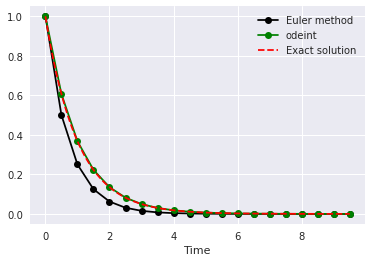

In [7]:
# Solve with Euler
t0 = 0
t1 = 10
h = 0.5

y0 = 1.0

T, Y = euler_solve(t0, t1, h, y0, rhs_function)

# Solve with odeint
sol = odeint(rhs_function, y0, T)

tFine = np.linspace(T[0], T[-1], 1000)

plt.plot(T, Y, 'k-o')
plt.plot(T, sol, 'g-o')
plt.plot(t_fine, real_solution(y0, tFine), 'r--')
plt.xlabel('Time')
plt.legend(['Euler method', 'odeint', 'Exact solution'])

It is evident that the more stable scheme used in odeint allows us to obtain a better solution using a larger timestep.

Now we investigate the behaviour of a more interesting system, the ['Brusselator'](https://en.wikipedia.org/wiki/Brusselator).

The Brusselator is a theoretical model for a type of autocatalytic chemical reaction.
Its behaviour is characterised by the following set of reactions:

1. $ A \rightarrow X $
2. $ 2X + Y \rightarrow 3X $
3. $ B + X \rightarrow Y + D $
4. $ X \rightarrow E $

Thus the rate equations for the full set of reactions can be written as 

$$
\frac{d[X]}{dt} = [A] + [X]^2[Y] - [B][X] - [X]
$$
$$
\frac{d[Y]}{dt} = [B][X] - [X]^2[Y]
$$

This system is interesting, since it exhibits stable dynamics for parameters in the range $ B < 1 + A^2 $; otherwise it operates in an unstable regime where the dynamics approach a limit cycle.

In [8]:
def bruss_odeint(y, t, a, b):
    '''
    RHS equations for the brusselator system.
    Arguments:
        y: the current state of the system
        t: time
        a, b: free parameters governing the dynamics
    Returns:
        dydt: the computed derivative at (y, t)
    '''
    # Unpack both species
    X, Y = y
    # Derivatives
    dydt = [
        a + Y*(X**2) - (b + 1)*X, # d[X]/dt
        b*X - Y*(X**2),           # d[Y]/dt
    ]
    return dydt

The first thing to do is to define the parameters of interest:

In [9]:
a = 1.0
b = 1.0

It is also necessary to define the initial conditions ($X(t_0)$ and $Y(t_0)$), and the time points over which we will integrate:

In [10]:
# Initial conditions
y0 = [0.5, 0.5]
# Time from 0 to 25
t = np.linspace(0, 25, 101)

Finally we can solve the system through a single call to `odeint`.

Note the function signature. `odeint()` requires the following arguments:
- The function we wish to integrate
- The initial point(s); these must have the same dimension as the derivative i.e., you need to have initial conditions specified for all dependent variables
- The time over which you wish to integrate
- Any additional arguments (optional) which will be passed to the function we're integrating; this is how we pass in our parameters

In [11]:
sol, info = odeint(bruss_odeint, y0, t, args = (a, b), full_output = True)

The variable `sol` (first returned value) contains the solution over the desired time points.

In [12]:
print('The number of time points is', len(t))
print('The solution matrix contains', sol.shape, 'entries')

The number of time points is 101
The solution matrix contains (101, 2) entries


As you can see, there is a column of solutions for each variable (X and Y, in this case).

So, we can plot these and observe the dynamics of our system.

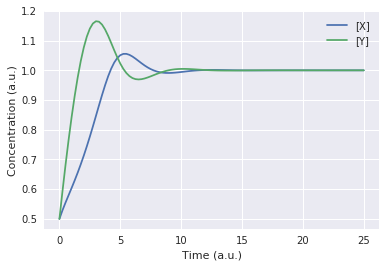

In [13]:
plt.figure()
plt.plot(t, sol[:, 0])
plt.plot(t, sol[:, 1])
plt.xlabel('Time (a.u.)')
plt.ylabel('Concentration (a.u.)')
plt.legend(['[X]', '[Y]'])

Additionally, you may have noticed that we return a second value called `info`. 

This stores a record about the numerical process underlying your results. This information can be useful in case you need to debug some experiments, and additionally if you want to start building some routines that use the integrator (e.g., you may want to adapt step sizes yourself, check if a part of the integration was successful, manually model discontinuities, ...).

In [14]:
print("Let's see what 'info' contains...:\n")
print(info)

Let's see what 'info' contains...:

{'hu': array([ 0.03742507,  0.07483344,  0.07483344,  0.10239397,  0.10239397,
        0.14782   ,  0.14782   ,  0.14782   ,  0.14782   ,  0.14782   ,
        0.17489196,  0.17489196,  0.17489196,  0.17489196,  0.17489196,
        0.17489196,  0.17489196,  0.17489196,  0.17489196,  0.17489196,
        0.17489196,  0.17489196,  0.17489196,  0.17489196,  0.135479  ,
        0.135479  ,  0.135479  ,  0.135479  ,  0.18669976,  0.18669976,
        0.18669976,  0.18669976,  0.18669976,  0.18669976,  0.15122555,
        0.15122555,  0.15122555,  0.15122555,  0.18571489,  0.18571489,
        0.18571489,  0.18571489,  0.18571489,  0.21501518,  0.21501518,
        0.21501518,  0.21501518,  0.21501518,  0.24942029,  0.24942029,
        0.24942029,  0.24942029,  0.24942029,  0.24942029,  0.24942029,
        0.21490015,  0.21490015,  0.21490015,  0.21490015,  0.21490015,
        0.2368049 ,  0.2368049 ,  0.2368049 ,  0.2368049 ,  0.2368049 ,
        0.32344692,  

These cryptically named fields are further detailed in the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html), but in summary:

- 'hu': vector of step sizes successfully used for each time step.
- 'tcur' vector with the value of t reached for each time step. (will always be at least as large as the input times).
- 'tolsf': vector of tolerance scale factors, greater than 1.0, computed when a request for too much accuracy was detected.
- 'tsw': value of t at the time of the last method switch (given for each time step)
- 'nst': cumulative number of time steps
- 'nfe': cumulative number of function evaluations for each time step
- 'nje': cumulative number of jacobian evaluations for each time step
- 'nqu': a vector of method orders for each successful step.
- 'imxer': index of the component of largest magnitude in the weighted local error vector (e / ewt) on an error return, -1 otherwise.
- 'lenrw': the length of the double work array required.
- 'leniw': the length of integer work array required.
- 'mused': a vector of method indicators for each successful time step: 1: adams (nonstiff), 2: bdf (stiff)

According to the condition defined previously ($ B < 1 + A^2 $) we ought to be able to destabilise the system by increasing the value of our parameter $B$.

Let's choose $ B = 2.5 $ and see what happens...

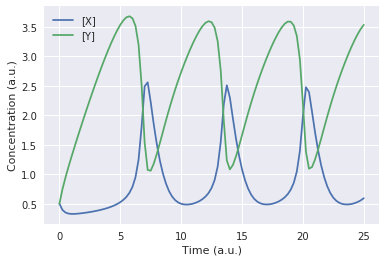

In [15]:
# Same variable as before
b = 2.5
# Again the solution method is the same; we are just passing in a new value of b
sol, info = odeint(bruss_odeint, y0, t, args = (a, b), full_output = True)
# Make the plot
plt.figure()
plt.plot(t, sol[:, 0])
plt.plot(t, sol[:, 1])
plt.xlabel('Time (a.u.)')
plt.ylabel('Concentration (a.u.)')
plt.legend(['[X]', '[Y]'])

Since we are simulating both $[X]$ and $[Y]$, we can quite trivially plot one against the other in a phase plane.

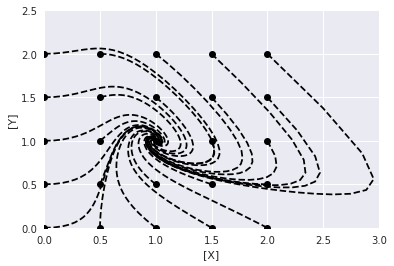

In [16]:
# Steady-state behaviour, for a longer time
b = 1.0
t = np.linspace(0, 50, 501)

# Construct a grid of initial points in the phase plane
X, Y = np.meshgrid(np.linspace(0, 2, 5), np.linspace(0, 2, 5))

plt.figure()

for y0 in zip(X.ravel(), Y.ravel()):
    sol, info = odeint(bruss_odeint, y0, t, args = (a, b), full_output = True)
    # Phase plane: we plt X vs Y, rather than a timeseries
    plt.plot(sol[:, 0], sol[:, 1], 'k--')
    # The initial point of the trajectory is a circle
    plt.plot(sol[0, 0], sol[0, 1], 'ko')
    
plt.xlim([0, 3])
plt.ylim([0, 2.5])

plt.xlabel('[X]')
plt.ylabel('[Y]')

If we're interested in seeing approximately when the transition from a stable steady state to a limit cycle occurs, we might instead plot a number of trajectories, using different values of $B$ rather than different intial conditions.

_Aside: Numerical methods ('continuation') for finding the actual value of $B$ at which the transition occurs (the 'bifurcation point') are beyond the scope of this tutorial, but are discussed briefly at the end of the section. _

### 2. Using `scipy.integrate.ode`

In many cases we will actually want more control over the numerical integration process. 

Helpfully, we have an alternative interface to various integration routines called simply `ode` ([documentation here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html)).
This is sold as a more object-oriented part of the module, but in fact it also provides more flexibility in terms of available solvers relative to `odeint`.

In [17]:
from scipy.integrate import ode

**⚠ Warning ⚠** the arguments of the right-hand-side function $f(t, y)$, that is passed to `ode()`, are reversed relative to `odeint()`!

I.e.,
- ** `odeint` ** expects a RHS function of the form `func(y, t, ...)`
- ** `ode` ** expects a RHS function of the form `func(t, y, ...)`

Consequently, we define a new function for the Brusselator, where these two arguments are now in the order expected by `ode()`.

In [18]:
def bruss_ode(t, y, a, b):
    '''
    The brusselator system, defined for scipy.integrate.ode
    '''
    # Unpack both species
    X, Y = y
    # Derivatives
    dydt = [
        a + Y*(X**2) - (b + 1)*X, # d[X]/dt
        b*X - Y*(X**2),           # d[Y]/dt
    ]
    return dydt

_Aside: We could also define this function just by swapping the arguments `t` and `y` in a wrapper function. 
This stops us from repeating code unnecessarily.
One way of doing this is as follows:_

```python
def bruss_ode(t, y, a, b):
    return bruss_odeint(y, t, a, b)
```

Generating a solution of the system is quite straightforward, it only requires us to call the function `ode.integrate()`. However obtaining the actual values of the solution can be done in multiple ways and depends a little on the solver you want to use.

Here we will illustrate the use of two solvers:
1. dopri5: higher-order solver
2. vode: another higher-order solver that has a nice implicit method (good for stiff systems) and can take adaptively-sized time steps.

In [19]:
def make_plot(traj):
    '''
    A helper function to plot trajectories
    '''
    t = traj[:, 0]
    y = traj[:, 1:]
    plt.figure()
    plt.plot(t, y[:, 0])
    plt.plot(t, y[:, 1])
    plt.xlabel('Time (a.u.)')
    plt.ylabel('Concentration (a.u.)')
    plt.legend(['[X]', '[Y]'])

#### Dopri5 Solver

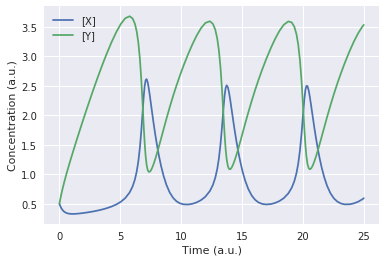

In [20]:
# Define parameters as before
a = 1.0
b = 2.5

# Define initial conditions
y0 = [0.5, 0.5]
t0 = 0

# Final time
t1 = 25

# Define the ODE solver object
solver = ode(bruss_ode).set_integrator('dopri5', nsteps = 10000)

# System/solver parameters are set as properties on the object
solver.set_initial_value(y0, t0).set_f_params(a, b)

# Dopri5 allows for a `solout` function to be attached.
# This function is run at the end of every complete timestep.
# We use it here just to append solutions to the full trajectory.
traj = []
def solout(t, y):
    traj.append([t, *y])

solver.set_solout(solout)

# Integrate until the full time
# (Also possible to take smaller sub-steps in a loop, as in the next section)
solver.integrate(t1)

# Form an array for easier manipulation
traj = np.asarray(traj)
make_plot(traj)

#### Vode Solver

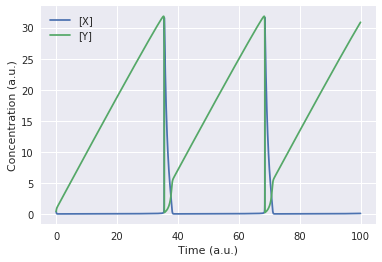

In [21]:
# Define parameters as before
a = 1.0
b = 10

# Define initial conditions
y0 = [0.5, 0.5]
t0 = 0

# Final time
t1 = 100

# Define the ODE solver object
solver = ode(bruss_ode).set_integrator('vode', method = 'bdf')

# System/solver parameters are set as properties on the object
solver.set_initial_value(y0, t0).set_f_params(a, b)

# We can't define a `solout` function, but we can automatically use
# the internal automatic step of the solver
traj = []
while solver.successful() and solver.t < t1:
    s = solver.integrate(t1, step = True)
    traj.append([solver.t, *s])

# Integrate until the full time
# (Also possible to take smaller sub-steps in a loop, as in the next section)
solver.integrate(t1)

traj = np.asarray(traj)
make_plot(traj)

### Some Performance Improvements: Using the Jacobian

We can specify the Jacobian, if known, to help the solver along a little bit. This will generally make the solution faster, and potentially allow the solver to perform fewer steps by providing knowledge about the system's derivatives _a priori_. 

More advanced packages, such as PyDSTool (mentioned below), may automatically compute a numerical or symbolic representation of the Jacobian in order to optimise simulation efficiency.

In [22]:
def bruss_jac(t, y, a, b):
    '''
    Jacobian function of the Brusselator.
    '''
    j = np.empty((2, 2))
    j[0, 0] = 2*y[0]*y[1] - (b + 1)
    j[0, 1] = y[0]**2
    j[1, 0] = b - 2*y[0]*y[1]
    j[1, 1] = - y[0]**2
    return j

In [23]:
# Previous trajectory
old_trajectory = traj.copy()

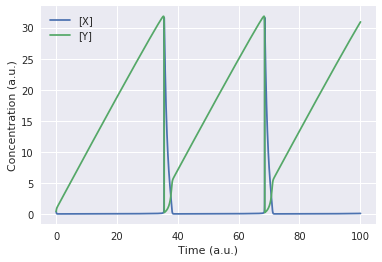

In [24]:
# Define parameters as before
a = 1.0
b = 10.0

# Define initial conditions
y0 = [0.5, 0.5]
t0 = 0

# Final time
t1 = 100

# Define the ODE solver object
solver = ode(bruss_ode, jac = bruss_jac).set_integrator('vode', method = 'bdf')

# System/solver parameters are set as properties on the object
solver.set_initial_value(y0, t0).set_f_params(a, b).set_jac_params(a, b)

# We can't define a `solout` function, but we can automatically use
# the internal automatic step of the solver
traj = []
while solver.successful() and solver.t < t1:
    s = solver.integrate(t1, step = True)
    traj.append([solver.t, *s])

# Integrate until the full time
# (Also possible to take smaller sub-steps in a loop, as in the next section)
solver.integrate(t1)

traj = np.asarray(traj)
make_plot(traj)

In [25]:
print('Original trajectory had dimensions', old_trajectory.shape)
print('New trajectory (w/ Jacobian) has dimensions', traj.shape)

Original trajectory had dimensions (3145, 3)
New trajectory (w/ Jacobian) has dimensions (1123, 3)


(0, 1200)

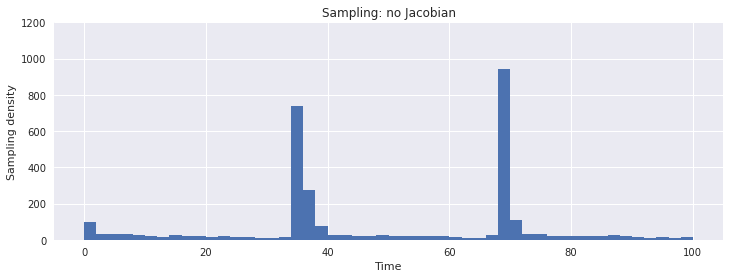

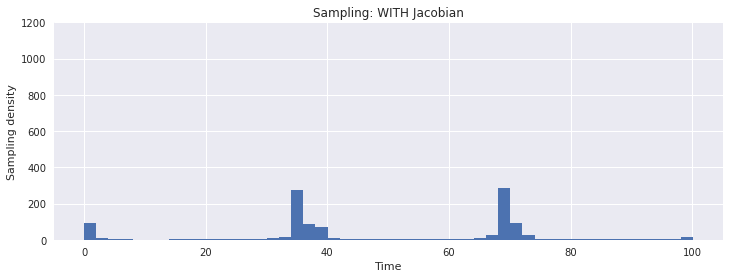

In [26]:
# Sampling density of original trajectory
plt.figure(figsize=(12, 4))
plt.hist(old_trajectory[:, 0], bins = 50)
plt.xlabel('Time')
plt.ylabel('Sampling density')
plt.title('Sampling: no Jacobian')
plt.ylim([0, 1200])

# Sampling density of original trajectory
plt.figure(figsize=(12, 4))
plt.hist(traj[:, 0], bins = 50)
plt.xlabel('Time')
plt.ylabel('Sampling density')
plt.title('Sampling: WITH Jacobian')
plt.ylim([0, 1200])

### An Illustration of Adaptive Sampling

One thing to bear in mind is that it's worth using an integration scheme that supports adaptive sampling of the integration step. this means that when the derivative is large, small steps are taken and _vice versa_; as a result, simulations tend to be more efficient.

What does this look like in practice?

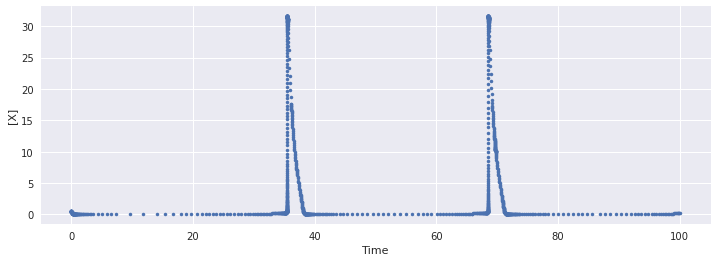

In [27]:
# Sampling density of new trajectory, as timeseries
plt.figure(figsize=(12, 4))
plt.plot(traj[:, 0], traj[:, 1], '.')
plt.xlabel('Time')
plt.ylabel('[X]')

It is quite obvious here that the sampling is dense in the regions where changes in $[X]$ are steep, and spreads out significantly in the regions where the gradient is small.

### Closing Comments

Finally, in reality you will probably want to do some more in-depth experiments and analysis with your system (and your system may be somewhat more complex than those presented today).

As an alternative to coding up your own solutions using the building blocks presented today, you could consider using the [PyDSTool](http://www.ni.gsu.edu/~rclewley/PyDSTool/FrontPage.html) package (its source code repository is [here](https://github.com/robclewley/pydstool). 
It provides quite a nice interface for modelling systems of ODEs, and additionally it does some quite clever stuff for you, saving time, effort, and testing, e.g., 
- it will compile your RHS functions in order to make simulations run faster
- integrators support adaptive timestepping
- automatic generation of Jacobians (and other numerical specifics) under the hood
- automatic generation of large ODE systems (e.g., networks of coupled systems)
and much more.

PyDSTool is partially integrated with the extremely powerful numerical continuation package [AUTO](http://cmvl.cs.concordia.ca/auto/) which allows you to perform bifurcation/continuation analysis of your system directly from PyDSTool. 

Somewhat tangentially, if you are eventually interested in numerical continuation you'll find that modern versions of AUTO include their own Python API which allows you to build your own analysis using the full feature set of AUTO.

## Scipy.optimize

At some point, you may find that you need to fit a model to some data. 

Here we refer to a model in quite a generic sense: this could be a regression or curve fit, the outcome of an ODE or PDE model, a complex black-box system such as a multi-scale finite element simulation of heat transfer in a nuclear reactor... 

The important thing to consider is that the model receives a set of parameters (is parametrised) as input, and provides some data as output. 
These simulated data may be directly comparable to experimentally acquired data, and in this case we may use an optimization routine to try to estimate the parameters of our model based on the experimental data.

Thus we may be able to use the model to infer hidden properties of the system, or to predict future behaviour.

To this end, a baseline set of useful tools is provided by the scipy.optimize package, and we will briefly go through some of these here.

### Curve Fitting

Arguably the most basic optimization procedure one can perform is to fit a curve to some experimentally observed points. 
This could be a straightforward linear regression, or a more complicated nonlinear curve.

This functionality is provided by the `scipy.optimize.curve_fit` function.
Internally the function uses a nonlinear least-squares method in order to minimize the distance between some data points and a curve function.

In [28]:
from scipy.optimize import curve_fit

In order to test the performance of the curve fitting provided by scipy, we will generate some synthetic data.
This data will take the form $ A \sin (\omega (x - t)) $, i.e., a sinusoidal curve with amplitude $A$, frequency $\omega$ and horizontal offset $t$.

In [29]:
def sinus(x, A, t, omega):
    '''
    Sine wave, over x
        A: the amplitude
        omega: the frequency
        t: the horizontal translation of the curve
    '''
    return A*np.sin(omega*(t + x))

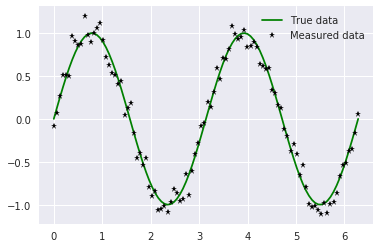

In [30]:
# The range of x over which we will observe the function
x = np.linspace(0, 2*np.pi, 100)

# The 'true' data, underlying an experimental observation
y_true = sinus(x, 1.0, 0, 2.0)

# 'Measured' experimental data (what we observed); noisy
y_measured = y_true + 0.1*np.random.randn(*y_true.shape)

plt.plot(x, y_true, 'g')
plt.plot(x, y_measured, '*k')
plt.legend(['True data', 'Measured data'])

To make our task a bit easier for this illustrative example we fix a couple of parameters and define a new function with these ($A = 1.0$ and $t = 0.0$), with only the frequency varying.

In [31]:
def fixed_sinus(x, p):
    '''
    Sinusoidal curve with all parameters fixed apart from frequency.
        p: frequency
    '''
    A = 1.0
    t = 0.0
    return sinus(x, A, t, p)

We can now try to fit this function to our noisy 'measured' data.

*** Fitted value of wavelength was:  [ 0.68137533] 



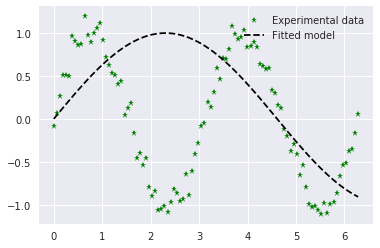

In [32]:
# Curve fit function: fits fixedSinus to measured data over x
popt, pcov = curve_fit(fixed_sinus, x, y_measured)

# Success?
print('*** Fitted value of wavelength was: ', popt, '\n')

plt.plot(x, y_measured, '*g')
plt.plot(x, fixed_sinus(x, popt), '--k')
plt.legend(['Experimental data', 'Fitted model'])

Hmm... This is clearly quite wrong!
It looks like although the function is quite powerful, maybe it needs a little help.
We can sugegst an initial value for the unknown parameter to see if that helps:

*** Fitted value of wavelength was:  [ 1.99843276] 



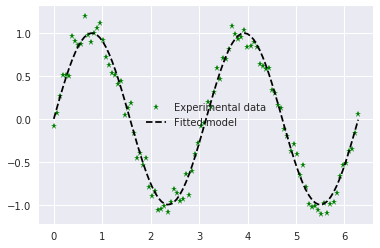

In [33]:
# Curve fit function: fits fixedSinus to measured data over x
# Now we add the keyword argument p0, which specifies an initial guess
popt, pcov = curve_fit(fixed_sinus, x, y_measured, p0 = 1.5)

# Success?
print('*** Fitted value of wavelength was: ', popt, '\n')

plt.plot(x, y_measured, '*g')
plt.plot(x, fixed_sinus(x, popt), '--k')
plt.legend(['Experimental data', 'Fitted model'])

Much better!

Obviously this is not great as in general you may not know a good starting parameter value (although you should have an idea of bounds and constraints especially if your model is not too abstract).

One way of getting around this is to initialise your fitting function from a bounded range of random initial values and choosing some that are markedly better.
Some optimisation routines will do (basically) this internally.

Another option is to choose a more robust optimisation method.

### More general minimization

`scipy.optimize` contains a fairly wide range of optimization routines.
In general these aim to _minimize_ some generic function, rather than to 'fit a curve' as we did a moment ago.

Therefore, in order to fit a model to some data using these methods, we must formulate an objective function.
This function can simply compute the distance, or _error_, between our desired outcome (the measured data) and the current output of the model.

In [34]:
def objective_function(par):
    '''
    Compute the sum of squares difference between the measured data and model output.
    '''
    # The current model prediction, based on the current parameters' values
    y_model = sinus(x, *par)
    # Sum-of-squares difference between the model and 'measured' data
    return np.sum(np.power(y_measured - y_model, 2.0))

The `scipy.optimize.minimize` function provides a general interface for minimization.

In [35]:
from scipy.optimize import minimize

Optimal parameters: 
Amplitude:  1.01467248702
Offset:  0.0235615326858
Frequency:  1.98773394011


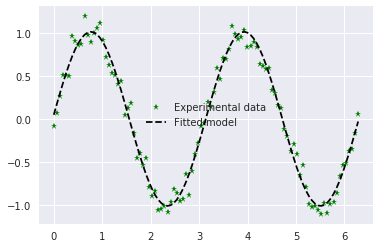

In [36]:
# We attempt to minimize our objective
# This function now contains the full (3 parameter) sin function,
# and so we need to provide 3 starting points; we choose [0.5, 0.5, 0.5]
opt = minimize(objective_function, [0.5]*3)
print('Optimal parameters: ')
print('Amplitude: ', opt.x[0])
print('Offset: ', opt.x[1])
print('Frequency: ', opt.x[2])

plt.plot(x, y_measured, '*g')
plt.plot(x, sinus(x, *opt.x), '--k')
plt.legend(['Experimental data', 'Fitted model'])

Not bad, considering it is more generic.

If we wanted further control over the process, we can also provide bounds as an optional keyword argument to the minimizer:

Optimal parameters: 
Amplitude:  0.0
Offset:  0.640118725223
Frequency:  5.17642687421


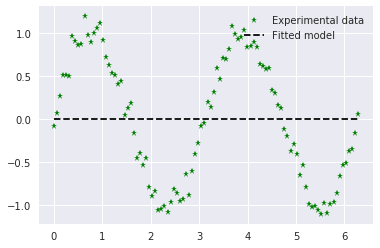

In [37]:
# Here we specify that the parameters must all be positive
bopt = minimize(objective_function, np.random.rand(3), bounds = [(0, None)]*3)
print('Optimal parameters: ')
print('Amplitude: ', bopt.x[0])
print('Offset: ', bopt.x[1])
print('Frequency: ', bopt.x[2])

plt.plot(x, y_measured, '*g')
plt.plot(x, sinus(x, *bopt.x), '--k')
plt.legend(['Experimental data', 'Fitted model'])

### Closing comments

This has just touched the surface of possibilities for numerical optimisation. As you can see, even the basic scipy installation provides some powerful algorithms: they may require a little tuning to get the results you need, but are in general quite robust and flexible.

In particular, the routines here are designed simply to perform one function: minimize an objective function.
Therefore, as long as you can specify an objective function appropriately, these algorithms may be useful (even if the actual computation of the objective function becomes more complicated).
For example fitting an ODE model to some time series would basically require that you specify your objective function as the difference between an experimental time series and your model under a certain parametrisation.

For working on more complex systems, or in cases where you have complicated or noisy data, other packages may present a more viable alternative. 
In reality, especially when dealing with noisy experimental data, it is crucial to choose the right optimisation routine for job. 
In many cases it may be beneficial to use a probabilistic method, for example, and often you will end up using **global optimizers**, which we didn't have time to go into today.

For example, some that I like to use are:
- [PySwarm](http://pythonhosted.org/pyswarm/): a simple constrained particle swarm optimisation tool
- [PyGMO](http://esa.github.io/pygmo/): a very powerful serial and parallel toolbox for constructing global optimisation routines
- [DEAP](https://github.com/DEAP/deap): another global optimisation package, strongly focused on large scale parallel evolutionary algorithms.